# Performance of MILP on sample 117 with $\alpha_1 = 1$, $\alpha_2 = 10$ and $\alpha_3 = 1$

In [1]:
from IPython.display import Image
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import linecache
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.display.max_columns = None

from IPython.display import Image

In [3]:
def parse_structure(filename):
    with open(filename) as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            # number of reference chromosomes:
            if line.startswith('number of reference c'):
                skip_ref_chromosomes = i + 1
                continue
                
            # number of reference plasmids:
            if line.startswith('number of reference p'):
                skip_ref_plasmids = i + 1
                continue
                
            # number of predicted plasmids:
            if line.startswith('number of p'):
                skip_pred_plasmids = i + 1
                continue
            
            # > predicted plasmid covers <proportion> of reference plasmid
            if line.startswith('> pr'):
                skip_ref_by_pred = i + 1
                continue
            
            # > reference plasmid covers <proportion> of predicted plasmid
            if line.startswith('> r'):
                skip_pred_by_ref = i + 1
                continue
                
            # > in total, how much of predicted plasmid is covered by reference plasmids
            if line.startswith('> in total, how much of p'):
                skip_pred_by_all = i + 1
                continue
                
            # > in total, how much of reference plasmid is covered by predicted plasmids
            if line.startswith('> in total, how much of r'):
                skip_ref_by_all = i + 1
                continue
            
            # > pairs of predicted and reference plasmids with coverage >= ... in both directions
            if line.startswith('> pa'):
                skip_mutual = i + 1
                continue
            
            # > summary scores
            if line.startswith('> s'):
                skip_summary_scores = i + 1
                break
        
        return skip_ref_chromosomes, skip_ref_plasmids, skip_pred_plasmids, skip_ref_by_pred, skip_pred_by_ref, \
                skip_pred_by_all, skip_ref_by_all, skip_mutual, skip_summary_scores

def read_table(file, skip_rows, num_rows, h = 0, s = '\t', col_sums = False, renaming = {}):
    df = pd.read_csv(file, skiprows = skip_rows, nrows = num_rows, sep = s, header = h)
    if col_sums:
        df.loc[len(df.index)] = ['Total'] + list(df.drop(df.columns[0], axis = 1).sum())
    df.rename(columns = renaming, inplace = True)
    return df

def list_plasmids(file, skip_rows, num_rows):
    df = read_table(file, skip_rows, num_rows, h = None, s = ' ', renaming = {0: 'plasmid', 1: 'length (nt)'})
    df.plasmid = [v[1:-1] for v in df.plasmid]
    return df[['plasmid', 'length (nt)']]

def list_scores(file, skip_rows, num_rows):
    df = read_table(file, skip_rows, num_rows, h = None, s = ' ', renaming = {0: 'score', 1: 'value'})
    df['score'] = [v[:-1].replace('score_ref_coverage', 'recall').replace('score_pred_coverage', 'precision').replace('overall_score', 'overall') for v in df['score']]
    return df

def list_correspondences(file, skip_rows, num_rows):
    first_line = linecache.getline(file, skip_rows + 1).strip()
    if first_line == 'none':
        print('No high mutual correspondence found.')
        #return pd.DataFrame({'reference': [], 'prediction': [], 'recall': [], 'precision': []})
    else:        
        df = read_table(file, skip_rows, num_rows, h = None, s = ' ', renaming = {0: 'reference', 2: 'prediction', 3: 'recall', 5: 'precision'})
        df['recall'] = [float(v[1:]) for v in df['recall']]
        df['precision'] = [float(v[:-1]) for v in df['precision']]
        return df[['reference', 'prediction', 'recall', 'precision']]
    
def plot_scores(information, score_labels):
    # information = list of tuples of from (file, label)
    pos = list(range(len(score_labels)))
    width = 1 / (len(information) + 2)

    fig, ax = plt.subplots(figsize = (10, 5))

    offset = -len(information) / 2
    for file, lab in information:
        plt.bar([p + offset * width for p in pos], list_scores(file, parse_structure(file)[-1], len(score_labels))['value'], width, label = lab)
        offset += 1

    ax.set_ylabel('score')
    ax.set_xticks([p - 0.5 * width for p in pos])
    ax.set_xticklabels(score_labels)
    ax.legend(bbox_to_anchor = (1, 0.5))

    plt.grid()
    plt.show()

*Precision*: proportion of predicted plasmid covered by reference plasmids (aka score_pred_coverage).

*Recall*: proportion of reference plasmid covered by predicted plasmids (aka score_ref_coverage).

In [4]:
score_labels = ['recall', 'precision', 'overall']

# evaluation files
sample_id = 117
MILP = "nplasmids_1/eval/MILP/MILP_eval.csv"
greedy_mean = "../../../../../../Plasmids-Assembly/exp/2018-07-20__sample_analyses_greedy_strategy/greedy_v2/L111/sample_%i/%i_greedy_mean.csv" % (sample_id, sample_id)

# reference information
_, skip_ref_plasmids, skip_pred_plasmids, _, _, _, _, _, _ = parse_structure(greedy_mean)
num_ref_plasmids = skip_pred_plasmids - skip_ref_plasmids - 3

#### List of reference plasmids

In [5]:
list_plasmids(greedy_mean, skip_ref_plasmids, num_ref_plasmids)

,plasmid,length (nt)
0,CP012934.1,3372
1,CP012932.1,2096
2,CP012933.1,3319
3,CP012935.1,3905
4,CP012936.1,98999
5,CP012931.1,236176


#### Overview of the scores on this sample for the different tools

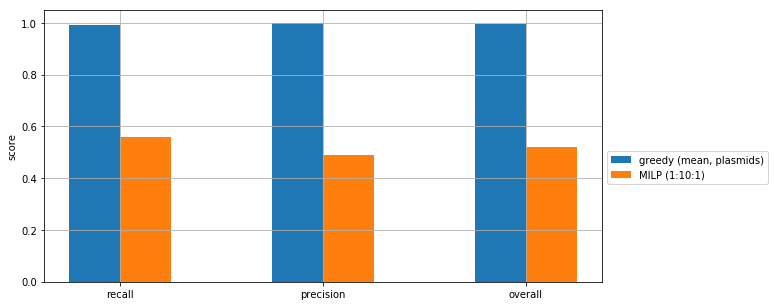

In [6]:
plot_scores([(greedy_mean, 'greedy (mean, plasmids)'), (MILP, 'MILP (1:10:1)')], score_labels)

## MILP output details

In [7]:
_, _, skip_pred_plasmids, skip_ref_by_pred, skip_pred_by_ref, skip_pred_by_all, skip_ref_by_all, \
    skip_mutual, skip_summary_scores = parse_structure(MILP)
num_pred_plasmids = skip_ref_by_pred - skip_pred_plasmids - 2
num_mutual = skip_summary_scores - skip_mutual - 2

#### List of predicted plasmids

In [8]:
list_plasmids(MILP, skip_pred_plasmids, num_pred_plasmids)

,plasmid,length (nt)
0,plasmid_0,194757
1,plasmid_1,92126
2,plasmid_2,70243
3,plasmid_3,168157
4,plasmid_4,5752
5,plasmid_5,13397
6,plasmid_6,64580


#### Precision and recall

In [9]:
list_scores(MILP, skip_summary_scores, len(score_labels))

,score,value
0,recall,0.559688
1,precision,0.488846
2,f1_score,0.521874


#### Proportion of reference plasmid (column) covered by individual predicted plasmid (row)

In [10]:
read_table(MILP, skip_ref_by_pred, num_pred_plasmids, renaming = {'Unnamed: 0': 'predicted'}, col_sums = True)

,predicted,CP012931.1,CP012932.1,CP012933.1,CP012934.1,CP012935.1,CP012936.1
0,plasmid_0,0.245152,0.000000,0.0,0.0,0.0,0.000000
1,plasmid_1,0.010416,0.040076,0.0,0.0,0.0,0.920595
2,plasmid_2,0.012033,0.000000,0.0,0.0,0.0,0.000000
3,plasmid_3,0.252341,0.040076,0.0,0.0,0.0,0.530844
4,plasmid_4,0.022890,0.000000,0.0,0.0,0.0,0.000000
5,plasmid_5,0.001617,0.000000,0.0,0.0,0.0,0.085758
6,plasmid_6,0.121608,0.000000,0.0,0.0,0.0,0.000000
7,Total,0.666058,0.080153,0.0,0.0,0.0,1.537197


#### Proportion of predicted plasmid (column) covered by individual reference plasmid (row)

In [11]:
read_table(MILP, skip_pred_by_ref, num_ref_plasmids, renaming = {'Unnamed: 0': 'reference'}, col_sums = True)

,reference,plasmid_0,plasmid_1,plasmid_2,plasmid_3,plasmid_4,plasmid_5,plasmid_6
0,CP012931.1,0.280611,0.008901,0.014393,0.345392,0.880042,0.014257,0.427872
1,CP012932.1,0.000000,0.000912,0.000000,0.000500,0.000000,0.000000,0.000000
2,CP012933.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,CP012934.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,CP012935.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,CP012936.1,0.000000,0.980016,0.000000,0.311227,0.000000,0.570725,0.000000
6,Total,0.280611,0.989829,0.014393,0.657118,0.880042,0.584982,0.427872


#### Proportion of predicted plasmid collectively covered by all reference plasmids

In [12]:
read_table(MILP, skip_pred_by_all, num_pred_plasmids)

,plasmid,proportion
0,plasmid_0,0.280611
1,plasmid_1,0.988917
2,plasmid_2,0.014393
3,plasmid_3,0.656619
4,plasmid_4,0.880042
5,plasmid_5,0.584982
6,plasmid_6,0.427872


#### Proportion of reference plasmid collectively covered by all predicted plasmids

In [13]:
read_table(MILP, skip_ref_by_all, num_ref_plasmids)

,plasmid,proportion
0,CP012931.1,0.407222
1,CP012932.1,0.040076
2,CP012933.1,0.000000
3,CP012934.1,0.000000
4,CP012935.1,0.000000
5,CP012936.1,0.994323


#### Correspondences between reference and predicted plasmids

In [14]:
list_correspondences(MILP, skip_mutual, num_mutual)

,reference,prediction,recall,precision
0,CP012936.1,plasmid_1,0.920595,0.980016


## Objective function values

The summary of the values of components of the objective functions has been provided below. These values have been computed for both the greedy and MILP approaches.

In [15]:
sample_dir = "../../../../../../Plasmids-Assembly/exp/2018-07-11__plasmid_contigs_from_genes/MOB-suite_samples/unicycler_pipeline/"
assembly_file = sample_dir + 'sample_' + str(sample_id) + '/assembly.gfa'
mapping_file = sample_dir + 'sample_' + str(sample_id) + '/filtered_genes_to_contigs.csv'
seeds_file = sample_dir + 'sample_' + str(sample_id) + '/seed_contigs.csv'

MILP_contig_chains = "nplasmids_1/MILP/contig_chains.csv"
greedy_contig_chains = "../../../../../../Plasmids-Assembly/exp/2018-07-20__sample_analyses_greedy_strategy/greedy_v2/L111/sample_%i/greedy_mean/contig_chains.csv" % (sample_id)


In [16]:
def read_file(filename):
	string = open(filename, "r").read()
	string_list = string.split("\n")
	string_list = [line for line in string_list if line and line[0] != '#'] #Read line only if it is nonempty and not a comment.
	return string_list

#Storing contig details
#-----------------------------------------------
#Stores the id of the contig
def get_id(line):
	return line[1]
#Stores the nucleotide sequence of the contig
def get_nucleotide_seq(line):
	#print(line[2])
	return line[2]		
#Computes GC ratio: counts no. of 'G'/'C' occurences in the sequence and divide by the sequence length.
def compute_GCratio(seq):
	GC = 0
	ln_seq = 0
	for nucl in seq:
		if nucl == 'G' or nucl == 'C':
			GC += 1
		ln_seq += 1
	return GC/ln_seq
#Stores the length of the sequence
def get_length(line):
	return int(line[3].split(':')[2])
#Stores the read depth of the contig
def get_read_depth(line):
	return float(line[4].split(':')[2])		

#Takes a contig from the assembly file and initiates an entry in the contigs_dict
#Each contig is tagged with the following attributes:
#1. Length of the contig (int)
#2. Overall read depth of the contig (float)
#3. Indication if the contig is a seed (binary)
#4. GC content of the contig (float)
#5. Gene coverage intervals (list of pairs)
#6. Gene coverage (float)
def update_contigs_dict(contigs_dict, line):
	c = get_id(line)
	seq = get_nucleotide_seq(line) 
	GC_cont = compute_GCratio(seq)
	ln = get_length(line)
	rd = get_read_depth(line)

	contigs_dict[c] = {}
	contigs_dict[c]['Sequence'] = seq
	contigs_dict[c]['Length'] = ln
	contigs_dict[c]['Read_depth'] = rd
	contigs_dict[c]['Seed'] = 0							#Default
	contigs_dict[c]['GC_cont'] = GC_cont
	contigs_dict[c]['Gene_coverage_intervals'] = []		#Default
	contigs_dict[c]['Gene_coverage'] = 0				#Default
	return contigs_dict

#A link is of the type: ((l1, e1),(l2, e2)) 
#where l1, l2 are adjacent links and e1, e2 are the connected link extremities
def get_link(line):
	c1, o1, c2, o2 = line[1], line[2], line[3], line[4]
	if o1 == '+':
		ext1 = 'h'
	else:
		ext1 = 't'
	if o2 == '+':
		ext2 = 't'
	else:
		ext2 = 'h'
	e = ((c1, ext1),(c2, ext2))	
	return e 

#Reads the assembly file line by line and forwards a line 
#to update_contigs_dict or get_link depending on the entry
def get_data(assembly_file, contigs_dict, links_list):
	string_list = read_file(assembly_file)
	count_s = 0
	count_l = 0
	for line in string_list:
		line = line.split("\t")
		if line[0] == 'S':
			contigs_dict = update_contigs_dict(contigs_dict, line)
		elif line[0] == 'L':
			e = get_link(line)
			links_list.append(e)
	return contigs_dict, links_list

#Reads the seed file and makes a list of seeds
def get_seeds(seeds_file, seeds_set):
	string_list = read_file(seeds_file)
	for line in string_list:
		line = line.split("\t")
		seeds_set.add(line[0])
	return seeds_set

#Takes the gene covering intervals for a contig and finds their union
#The length of the union is used to compute gene coverage
def get_union(intervals):
	union = []
	for begin, end in sorted(intervals):
		if union and union[-1][1] >= begin - 1:
			union[-1][1] = max(union[-1][1], end)
		else:
			union.append([begin, end])
	return union		

#Computes the gene coverage for each contig
def get_gene_coverage(mapping_file, contigs_dict):
	string_list = read_file(mapping_file)
	possible_seeds = []
	for line in string_list:
		line = line.split("\t")	
		qseqid, sseqid = line[0], line[1]
		sstart, send = line[8], line[9]
		if sseqid not in possible_seeds:
			possible_seeds.append(sseqid)
		if sseqid not in contigs_dict:
			print(sseqid, "not in contigs_dict")
		else:
			if int(sstart) > int(send):
				contigs_dict[sseqid]['Gene_coverage_intervals'].append((int(send), int(sstart)))
			else:
				contigs_dict[sseqid]['Gene_coverage_intervals'].append((int(sstart), int(send)))

	for sseqid in contigs_dict:
		union = get_union(contigs_dict[sseqid]['Gene_coverage_intervals'])
		ln = contigs_dict[sseqid]['Length']
		covered = 0
		for interval in union:
			covered += interval[1] - interval[0] + 1
		contigs_dict[sseqid]['Gene_coverage'] = covered/ln

	return contigs_dict

In [17]:
contigs_dict = {}
links_list = []
seeds_set = set()

contigs_dict, links_list = get_data(assembly_file, contigs_dict, links_list)
seeds_set = get_seeds(seeds_file, seeds_set)
contigs_dict = get_gene_coverage(mapping_file, contigs_dict)

GC_total = 0
ln_total = 0
for c in contigs_dict:
	GC_total += contigs_dict[c]['GC_cont']*contigs_dict[c]['Length']
	ln_total += contigs_dict[c]['Length']
	
GC_mean = GC_total/ln_total	

In [18]:
def get_obj_val(chain):
    gd_sum, GC_sum = 0, 0
    a2, a3 = 10, 1
    a_total = a2+a3
    p_len = 0
    for c in chain:
        gd = contigs_dict[c]['Gene_coverage']
        ln = contigs_dict[c]['Length']
        GC = contigs_dict[c]['GC_cont']
        p_len += ln
        gd_sum += -(a2/a_total)*gd*ln
        GC_sum += -(a3/a_total)*(GC_mean-GC)*ln
    gd_sum = gd_sum/p_len
    GC_sum = GC_sum/p_len
    total = gd_sum + GC_sum
    return gd_sum, GC_sum, total
    

In [19]:
MILP_plasmids = {}
greedy_plasmids = {}

plasmids = open(MILP_contig_chains, "r").read()
plasmid_list = plasmids.split("\n")
for line in plasmid_list:
    if line:
        p_id = line.split(";")[0]
        #print(p_id)
        chain = line.split(";")[1].split(",")
        chain = [x[0:-1] for x in chain]
        MILP_plasmids[p_id] = {}
        MILP_plasmids[p_id]['chain'] = chain
        MILP_plasmids[p_id]['gd_sum'], MILP_plasmids[p_id]['GC_sum'], MILP_plasmids[p_id]['total'] = get_obj_val(chain)
        #print(chain)

        
plasmids = open(greedy_contig_chains, "r").read()
plasmid_list = plasmids.split("\n")
for line in plasmid_list:
    if line:
        p_id = line.split(";")[0]
        #print(p_id)
        chain = line.split(";")[1].split(",")
        chain = [x[0:-1] for x in chain]
        greedy_plasmids[p_id] = {}
        greedy_plasmids[p_id]['chain'] = chain
        greedy_plasmids[p_id]['gd_sum'], greedy_plasmids[p_id]['GC_sum'], greedy_plasmids[p_id]['total'] = get_obj_val(chain)
        #print(chain)        

In [20]:
MILP_obj = pd.DataFrame(MILP_plasmids)
MILP_obj.rename(columns = {0: 'Plasmid', 1: 'Chain', 2: 'gd', 3: 'GC', 4: 'Total'}, inplace = True)

In [21]:
MILP_obj

,plasmid_0,plasmid_1,plasmid_2,plasmid_3,plasmid_4,plasmid_5,plasmid_6
GC_sum,-0.00615695,-0.00230566,-0.000499113,-0.00196103,0.00805273,0.000914784,-0.00028907
chain,"[43, 11, 42, 35, 15]","[49, 17, 62, 16, 47, 43]","[48, 92, 108, 104, 34, 106, 100, 27, 40, 19, 7...","[49, 17, 62, 23, 71, 19, 40, 27, 100, 106, 34,...","[26, 53, 44]","[62, 23, 58, 109, 35, 28]","[71, 19, 40, 27, 100, 106, 34, 86, 72, 107, 48..."
gd_sum,-0.742865,-0.808754,-0.383676,-0.612209,-0.840024,-0.801672,-0.355148
total,-0.749022,-0.81106,-0.384175,-0.61417,-0.831971,-0.800757,-0.355437


In [22]:
greedy_obj = pd.DataFrame(greedy_plasmids)
greedy_obj.rename(columns = {0: 'Plasmid', 1: 'Chain', 2: 'gd', 3: 'GC', 4: 'Total'}, inplace = True)

In [23]:
greedy_obj

,plasmid_0,plasmid_1,plasmid_10,plasmid_11,plasmid_12,plasmid_13,plasmid_2,plasmid_3,plasmid_4,plasmid_5,plasmid_6,plasmid_7,plasmid_8,plasmid_9
GC_sum,-0.0062533,-0.00259313,-5.94052e-05,-0.000119691,0.000544323,0.000550089,-0.000836153,-0.00267233,-0.00770681,-0.000701078,0.00336402,-0.00539855,-0.00456856,-0.00700929
chain,"[53, 44, 43, 11, 42, 58, 24, 58]","[35, 42, 15, 35, 28, 43, 20, 43, 54, 53, 26, 53]","[21, 91, 45, 6, 91]","[1, 45, 8, 93]","[45, 4]",[43],"[17, 49, 17, 62, 23]","[62, 23, 62, 16, 47, 16]",[32],[29],[33],[47],[58],[49]
gd_sum,-0.751537,-0.762542,-0.00174809,-0.000431608,-0.00126228,-0.909091,-0.827408,-0.795688,-0.561505,-0.702596,-0.429389,-0.909091,-0.909091,-0.835989
total,-0.75779,-0.765135,-0.00180749,-0.000551299,-0.000717953,-0.908541,-0.828244,-0.79836,-0.569212,-0.703297,-0.426025,-0.914489,-0.913659,-0.842998


#### Finding intersections or subsets

In [24]:
for x in greedy_plasmids:
    x_chain = greedy_plasmids[x]['chain']
    for y in MILP_plasmids:
        y_chain = MILP_plasmids[y]['chain']
        if set(y_chain) <= set(x_chain):
            print(y, ' from MILP completely contained in ', x, ' from greedy.\n')
        if set(x_chain) <= set(y_chain):
            print(x, ' from greedy completely contained in ', y, ' from MILP.\n')    

plasmid_2  from greedy completely contained in  plasmid_3  from MILP.

plasmid_7  from greedy completely contained in  plasmid_1  from MILP.

plasmid_8  from greedy completely contained in  plasmid_2  from MILP.

plasmid_8  from greedy completely contained in  plasmid_5  from MILP.

plasmid_8  from greedy completely contained in  plasmid_6  from MILP.

plasmid_9  from greedy completely contained in  plasmid_1  from MILP.

plasmid_9  from greedy completely contained in  plasmid_3  from MILP.

plasmid_13  from greedy completely contained in  plasmid_0  from MILP.

plasmid_13  from greedy completely contained in  plasmid_1  from MILP.

plasmid_13  from greedy completely contained in  plasmid_2  from MILP.

